<a href="https://colab.research.google.com/github/ishqDehlvi/LipNet/blob/master/Notebooks/complete-2-models-with-detailed-accuracy-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiohappyeyeballs                   2.4.3
aiohttp                            3.11.2
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.6
astropy-iers-data                  0.2024.11.18.0.35.2
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread           

In [ ]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt


In [3]:
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7e2ad44b-f8aa-4ca2-88fc-61ef98c81383
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 62.9MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str):
#     path = bytes.decode(path.numpy())
#     print(path)
    file_name = path.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    # File name splitting for windows
#     file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments
#     return file_name

In [16]:
test_path = './data/s1/bbal6n.mpg'

In [ ]:
# test_path = bytes.decode(test_path.numpy())

In [ ]:
# hi = tf.convert_to_tensor(test_path).numpy().decode('utf-8')
# hi

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

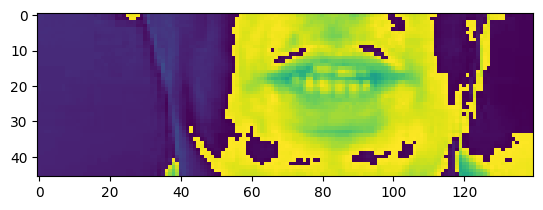

In [20]:
plt.imshow(frames[40])

In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [24]:
from matplotlib import pyplot as plt

In [25]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [26]:
len(train)

450

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
sample = data.as_numpy_iterator()

In [ ]:
# len(sample)

In [30]:
val = sample.next(); val[0]

array([[[[[ 1.2339853 ],
          [ 1.3534032 ],
          [ 1.1941793 ],
          ...,
          [ 0.23883587],
          [ 0.23883587],
          [ 0.23883587]],

         [[ 1.1941793 ],
          [ 1.3534032 ],
          [ 1.1543734 ],
          ...,
          [ 0.23883587],
          [ 0.23883587],
          [ 0.23883587]],

         [[ 1.3534032 ],
          [ 1.1543734 ],
          [ 0.8359255 ],
          ...,
          [ 0.27864185],
          [ 0.1990299 ],
          [ 0.1990299 ]],

         ...,

         [[ 1.1145674 ],
          [ 1.1145674 ],
          [ 1.0747614 ],
          ...,
          [ 0.        ],
          [10.150524  ],
          [10.150524  ]],

         [[ 1.1145674 ],
          [ 1.1145674 ],
          [ 1.0349554 ],
          ...,
          [ 0.        ],
          [10.150524  ],
          [10.150524  ]],

         [[ 1.1145674 ],
          [ 1.1145674 ],
          [ 1.0349554 ],
          ...,
          [ 0.        ],
          [10.150524  ],
          

In [ ]:

# for i in range (50):
#     val = sample.next()

#     print(i,val[0][0][0][0][0])
#     print(tf.strings.reduce_join([num_to_char(word) for word in val[1][0]]))
#     yhat = model.predict(val[0])
#     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
#     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))

In [ ]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

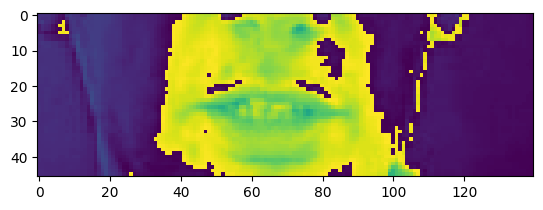

In [31]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with b five again'>

# 3. Design the Deep Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [34]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# url = 'https://drive.google.com/file/d/1fyZoYgqZw_aRa66kiOR6J8XLu3Y9wfMg/view?usp=sharing'
# url = 'https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download'
# output = 'check.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('check.zip', 'models')

In [ ]:
# model.load_weights('./models/models/checkpoint')

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
5*17*75

6375

In [38]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [39]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'9999999222222222224422222444444444444444444444444444444444444444444444444??'>

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'9999999222222222224422222444444444444444444444444444444444444444444444444??'>

In [41]:
model.input_shape

(None, 75, 46, 140, 1)

In [42]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [47]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=CTCLoss)

In [54]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [55]:
schedule_callback = LearningRateScheduler(scheduler)

In [56]:
example_callback = ProduceExample(test)

In [ ]:
# model.fit(train, validation_data=test, epochs=46, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [ ]:
# model.load_weights('./models/checkpoint')

In [57]:
test_data = data.as_numpy_iterator()

In [58]:
sample = test_data.next()

In [59]:
sample[0].shape

(2, 75, 46, 140, 1)

In [60]:
sample[1].shape

(2, 40)

In [61]:
sample[1]

array([[19,  5, 20, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 15, 39, 19,
         9, 24, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  2, 25, 39,  3, 39, 14,
         9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [62]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [63]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with o six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green by c nine again'>]

In [ ]:
# for i in range (50):
#     val = sample.next()

# #     print(i,val[0][0][0][0][0])
#     og = tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])
#     print(og)
#     yhat = model.predict(val[0])
# #     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
# #     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
#     decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
#     predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
#     print(predicted)

In [64]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [65]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'y?4?2?4n'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'9?9?2?'>]

# Test on a Video

In [66]:
sample1 = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [67]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample1[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [68]:
yhat = model.predict(tf.expand_dims(sample1[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [69]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [70]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'9?'>]

In [71]:
len(test)

50

# Accuracy Analysis

### On 50-Epoch Trained Model

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download'
output = 'check.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('check.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download
From (redirected): https://drive.google.com/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download&confirm=t&uuid=7723e342-c7d6-49f5-a2ce-8865a8d420ca
To: /kaggle/working/check.zip
100%|██████████| 95.3M/95.3M [00:02<00:00, 32.4MB/s]


['models/models/checkpoint',
 'models/models/checkpoint.index',
 'models/models/checkpoint.data-00000-of-00001']

In [ ]:
model.load_weights('./models/models/checkpoint')

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data = data.as_numpy_iterator()

In [ ]:
def levenshtein_distance(str1, str2):
    len_str1 = len(str1) + 1
    len_str2 = len(str2) + 1

    # Initialize a matrix to store edit distances
    matrix = [[0] * len_str2 for _ in range(len_str1)]

    # Initialize the first row and column of the matrix
    for i in range(len_str1):
        matrix[i][0] = i
    for j in range(len_str2):
        matrix[0][j] = j

    # Fill in the matrix using dynamic programming
    for i in range(1, len_str1):
        for j in range(1, len_str2):
            cost = 0 if str1[i - 1] == str2[j - 1] else 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,      # Deletion
                matrix[i][j - 1] + 1,      # Insertion
                matrix[i - 1][j - 1] + cost  # Substitution
            )

    return matrix[len_str1 - 1][len_str2 - 1]

def calculate_word_error_rate(reference, hypothesis):
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()

    # Calculate Levenshtein distance between reference and hypothesis words
    distance = levenshtein_distance(reference_words, hypothesis_words)

    # Calculate Word Error Rate
    wer = distance / len(reference_words)
    return wer

def calculate_sentence_error_rate(reference, hypothesis):
    # Calculate Levenshtein distance between reference and hypothesis sentences
    distance = levenshtein_distance(reference, hypothesis)

    # Calculate Sentence Error Rate
    ser = distance / len(reference)
    return ser

In [ ]:
word_error_rates_for_model1=[]
sentence_error_rates_for_model1=[]

In [ ]:
for i in range (500):
    try:
        sample = test_data.next()

        #     print(i,val[0][0][0][0][0])
        og = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
        #     og = tf.strings.reduce_join([num_to_char(word) for word in sample[1][0]])

        yhat = model.predict(sample[0])
        #     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
        #     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
        predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


        reference_string = str(og[1])[11:-25]
        hypothesis_string = str(predicted[1])[11:-25]

        wer = calculate_word_error_rate(reference_string, hypothesis_string)
        ser = calculate_sentence_error_rate(reference_string, hypothesis_string)

        word_error_rates_for_model1.append(wer)
        sentence_error_rates_for_model1.append(ser)

        if i<10: # print results for first 10 sentences

            print(og[1])
            print("Real Sentence",str(og[1])[11:-25])

            print(predicted[1])
            print("Sentence Predicted",str(predicted[1])[11:-25])

            print(f"Word Error Rate: {wer * 100:.2f}%")
            print(f"Sentence Error Rate: {ser * 100:.2f}%")

            print()
    except:
        pass


1/1 [==============================] - 0s 119ms/step
tf.Tensor(b'set green at i nine again', shape=(), dtype=string)
Real Sentence 'set green at i nine again'
tf.Tensor(b'set green at nine again', shape=(), dtype=string)
Sentence Predicted 'set green at nine again'
Word Error Rate: 16.67%
Sentence Error Rate: 7.41%

1/1 [==============================] - 0s 118ms/step
tf.Tensor(b'set blue with h seven soon', shape=(), dtype=string)
Real Sentence 'set blue with h seven soon'
tf.Tensor(b'set blue with seven soon', shape=(), dtype=string)
Sentence Predicted 'set blue with seven soon'
Word Error Rate: 16.67%
Sentence Error Rate: 7.14%

1/1 [==============================] - 0s 116ms/step
tf.Tensor(b'place sp blue at i six please', shape=(), dtype=string)
Real Sentence 'place sp blue at i six please'
tf.Tensor(b'place blue at six please', shape=(), dtype=string)
Sentence Predicted 'place blue at six please'
Word Error Rate: 28.57%
Sentence Error Rate: 16.13%

1/1 [==========================

[mpeg1video @ 0x7e69500610c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e69500610c0] Warning MVs not available


1/1 [==============================] - 0s 121ms/step


In [ ]:
mean_wer=sum(word_error_rates_for_model1)/len(word_error_rates_for_model1)
mean_ser=sum(sentence_error_rates_for_model1)/len(sentence_error_rates_for_model1)

print("For Model 1")
print(f"Mean Word Error Rate: {mean_wer * 100:.2f}%")
print(f"Mean Sentence Error Rate: {mean_ser * 100:.2f}%")

For Model 1
Mean Word Error Rate: 14.40%
Mean Sentence Error Rate: 6.06%


In [ ]:
# print("Max For Model 1")
# print(f"Mean Word Error Rate: {max(word_error_rates_for_model1) * 100:.2f}%")
# print(f"Mean Sentence Error Rate: {max(sentence_error_rates_for_model1) * 100:.2f}%")

In [ ]:
len(word_error_rates_for_model1)

498

### On 96-Epoch trained model

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=20684f54-1d09-4fa2-bb80-33ebd517253d
To: /kaggle/working/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:02<00:00, 31.9MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('./models/checkpoint')

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data = data.as_numpy_iterator()

In [ ]:
word_error_rates_for_model2=[]
sentence_error_rates_for_model2=[]

0.34615384615384615

In [ ]:
for i in range (500):
    sample = test_data.next()

#     print(i,val[0][0][0][0][0])
    og = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
#     og = tf.strings.reduce_join([num_to_char(word) for word in sample[1][0]])

    yhat = model.predict(sample[0])
#     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
#     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


    reference_string = str(og[1])[11:-25]
    hypothesis_string = str(predicted[1])[11:-25]

    wer = calculate_word_error_rate(reference_string, hypothesis_string)
    ser = calculate_sentence_error_rate(reference_string, hypothesis_string)

    word_error_rates_for_model2.append(wer)
    sentence_error_rates_for_model2.append(ser)

    if i<10: # print results for first 10 sentences

        print(og[1])
        print("Real Sentence",str(og[1])[11:-25])

        print(predicted[1])
        print("Sentence Predicted",str(predicted[1])[11:-25])

        print(f"Word Error Rate: {wer * 100:.2f}%")
        print(f"Sentence Error Rate: {ser * 100:.2f}%")

        print()


1/1 [==============================] - 0s 124ms/step
tf.Tensor(b'bin red at m five again', shape=(), dtype=string)
Real Sentence 'bin red at m five again'
tf.Tensor(b'bin red at m five again', shape=(), dtype=string)
Sentence Predicted 'bin red at m five again'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [==============================] - 0s 117ms/step
tf.Tensor(b'place red with d six please', shape=(), dtype=string)
Real Sentence 'place red with d six please'
tf.Tensor(b'place red with d six please', shape=(), dtype=string)
Sentence Predicted 'place red with d six please'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [==============================] - 0s 115ms/step
tf.Tensor(b'place white by q seven again', shape=(), dtype=string)
Real Sentence 'place white by q seven again'
tf.Tensor(b'place white by q seven again', shape=(), dtype=string)
Sentence Predicted 'place white by q seven again'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [====================

[mpeg1video @ 0x7e6b340c4600] ac-tex damaged at 22 17
[mpeg1video @ 0x7e6b340c4600] Warning MVs not available


1/1 [==============================] - 0s 113ms/step


In [ ]:
len(word_error_rates_for_model2)

500

In [ ]:
mean_wer=sum(word_error_rates_for_model2)/len(word_error_rates_for_model2)
mean_ser=sum(sentence_error_rates_for_model2)/len(sentence_error_rates_for_model2)

print("For Model 2")
print(f"Mean Word Error Rate: {mean_wer * 100:.8f}%")
print(f"Mean Sentence Error Rate: {mean_ser * 100:.8f}%")

For Model 2
Mean Word Error Rate: 1.76666667%
Mean Sentence Error Rate: 0.67408067%


In [ ]:
# print("Max For Model 2")
# print(f"Mean Word Error Rate: {max(word_error_rates_for_model2) * 100:.8f}%")
# print(f"Mean Sentence Error Rate: {max(sentence_error_rates_for_model2) * 100:.8f}%")